# **Modelo Original**

## **Modelos de prueba**

In [12]:
import pandas as pd
fraude_train = pd.read_csv("fraude_train.csv") 

In [19]:
import joblib

# Cargar modelos
knn_model = joblib.load("knn_model.pkl")
rf_model = joblib.load("rf_model.pkl")
xgb_model = joblib.load("xgb_model.pkl")
ridge_model = joblib.load("ridge_model.pkl")



In [20]:
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

# Separar variables
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Balanceo SOLO en entrenamiento
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import time

# === Redefinir pipelines base desde cero (sin cargar los .pkl)
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=9))
])

pipe_rf = Pipeline([
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

pipe_xgb = Pipeline([
    ('xgb', XGBClassifier(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.2,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',               # FORZAR CPU
        predictor='cpu_predictor',        # FORZAR CPU
        random_state=42,
        n_jobs=-1
    ))
])

# === Lista de modelos base
estimators = [
    ('knn', pipe_knn),
    ('rf', pipe_rf),
    ('xgb', pipe_xgb)
]

# === Meta-modelo
meta_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# === StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# === GridSearchCV para C
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_stack = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === Entrenamiento
start_time = time.time()
grid_search_stack.fit(X_train_bal, y_train_bal)
end_time = time.time()

print(f"\nTiempo total entrenamiento y búsqueda (Stacking): {end_time - start_time:.2f} segundos")
print("Mejor C:", grid_search_stack.best_params_['final_estimator__C'])
print("Mejor AUC promedio:", grid_search_stack.best_score_)


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits

Tiempo total entrenamiento y búsqueda (Stacking): 1395.45 segundos
Mejor C: 10
Mejor AUC promedio: 0.9979746149993349


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import time

# === Definir modelos base (deben ser pipelines ya entrenados)
estimators = [
    ('knn', knn_model),
    ('rf', rf_model),
    ('xgb', xgb_model)
]


# === Meta-modelo: regresión logística regularizada
meta_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# === Crear el stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,            # validación interna para el meta-modelo
    passthrough=False,  # no pasar X además de predicciones
    n_jobs=-1
)

# === Validación cruzada externa + búsqueda de hiperparámetros del meta-modelo (C)
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_stack = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === Entrenamiento con tiempo
start_time = time.time()
grid_search_stack.fit(X_train_bal, y_train_bal)
end_time = time.time()

print(f"\nTiempo total entrenamiento y búsqueda (Stacking): {end_time - start_time:.2f} segundos")
print("Mejor C:", grid_search_stack.best_params_['final_estimator__C'])
print("Mejor AUC promedio:", grid_search_stack.best_score_)


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\Asus\anaconda3\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Asus\anaconda3\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 136, in __call__
    retu


Tiempo total entrenamiento y búsqueda (Stacking): 1969.03 segundos
Mejor C: 0.01
Mejor AUC promedio: 0.9981442085534713


In [5]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import time
'''
# Por si se desea suprimir el warning de ajuste fallido
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=FitFailedWarning)
'''


# === Definir modelos base (deben ser pipelines ya entrenados)
estimators = [
    ('knn', knn_model),
    ('rf', rf_model),
    ('xgb', xgb_model)
]


# === Meta-modelo: regresión logística regularizada
meta_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# === Crear el stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,            # validación interna para el meta-modelo
    passthrough=False,  # no pasar X además de predicciones
    n_jobs=-1
)

# === Validación cruzada externa + búsqueda de hiperparámetros del meta-modelo (C)
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_stack = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === Entrenamiento con tiempo
start_time = time.time()
grid_search_stack.fit(X_train_bal, y_train_bal)
end_time = time.time()

print(f"\nTiempo total entrenamiento y búsqueda (Stacking): {end_time - start_time:.2f} segundos")
print("Mejor C:", grid_search_stack.best_params_['final_estimator__C'])
print("Mejor AUC promedio:", grid_search_stack.best_score_)


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\Asus\anaconda3\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Asus\anaconda3\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 136, in __call__
    retu


Tiempo total entrenamiento y búsqueda (Stacking): 1969.03 segundos
Mejor C: 0.01
Mejor AUC promedio: 0.9981442085534713


In [10]:
from sklearn.metrics import classification_report

# === Mejor modelo del GridSearchCV
best_stack_model = grid_search_stack.best_estimator_

# === Predicciones sobre el test original
y_pred_stack = best_stack_model.predict(X_test)
y_proba_stack = best_stack_model.predict_proba(X_test)[:, 1]

# === Reporte de clasificación
print("\n=== Classification Report - Stacking ===")
print(classification_report(y_test, y_pred_stack))



=== Classification Report - Stacking ===
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     39871
         1.0       0.74      0.69      0.72      3395

    accuracy                           0.96     43266
   macro avg       0.86      0.84      0.85     43266
weighted avg       0.96      0.96      0.96     43266



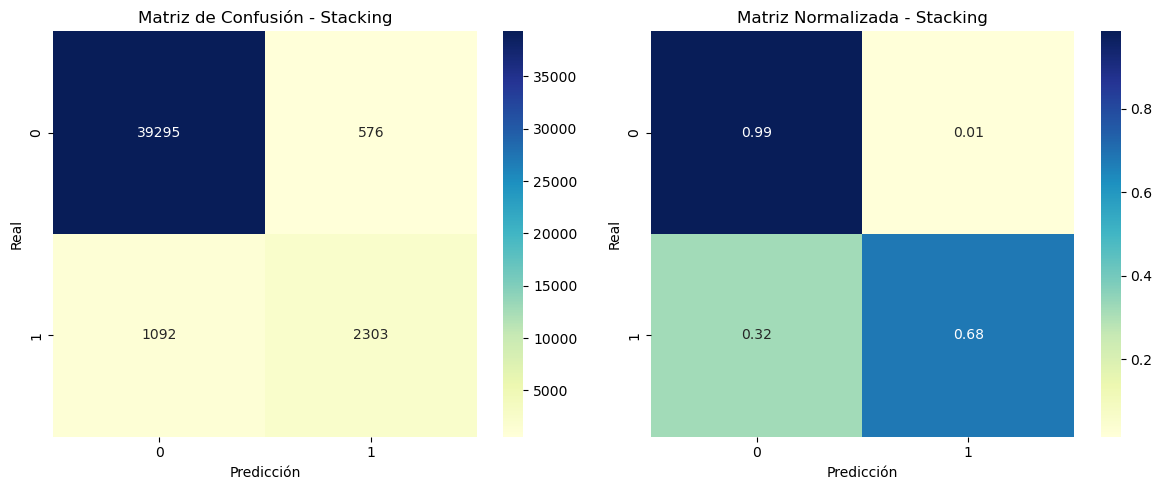

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Matrices
cm_stack = confusion_matrix(y_test, y_pred_stack)
cm_stack_norm = confusion_matrix(y_test, y_pred_stack, normalize='true')

# === Gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_stack, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0])
axes[0].set_title("Matriz de Confusión - Stacking")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_stack_norm, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[1])
axes[1].set_title("Matriz Normalizada - Stacking")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()


AUC final sobre test (Stacking): 0.9333


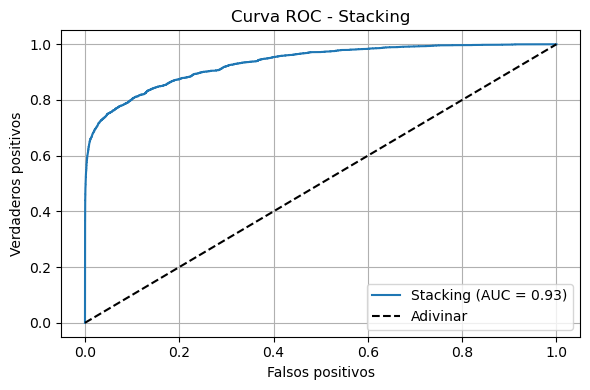

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

# === Curva ROC
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_proba_stack)
auc_stack = roc_auc_score(y_test, y_proba_stack)
print(f"AUC final sobre test (Stacking): {auc_stack:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr_stack, tpr_stack, label=f'Stacking (AUC = {auc_stack:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Stacking")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Intento 2

In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import time

# === Redefinir pipelines base desde cero (sin cargar los .pkl)
''''
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=9))
])
'''


pipe_rf = Pipeline([
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

pipe_xgb = Pipeline([
    ('xgb', XGBClassifier(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.2,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',               # FORZAR CPU
        predictor='cpu_predictor',        # FORZAR CPU
        random_state=42,
        n_jobs=-1
    ))
])

# === Lista de modelos base
estimators = [
    #('knn', pipe_knn),
    ('rf', pipe_rf),
    ('xgb', pipe_xgb)
]

# === Meta-modelo
meta_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# === StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# === GridSearchCV para C
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_stack = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === Entrenamiento
start_time = time.time()
grid_search_stack.fit(X_train_bal, y_train_bal)
end_time = time.time()

print(f"\nTiempo total entrenamiento y búsqueda (Stacking): {end_time - start_time:.2f} segundos")
print("Mejor C:", grid_search_stack.best_params_['final_estimator__C'])
print("Mejor AUC promedio:", grid_search_stack.best_score_)


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits

Tiempo total entrenamiento y búsqueda (Stacking): 1399.55 segundos
Mejor C: 0.01
Mejor AUC promedio: 0.9950874872142867


In [13]:
from sklearn.metrics import classification_report

# === Mejor modelo del GridSearchCV
best_stack_model = grid_search_stack.best_estimator_

# === Predicciones sobre el test original
y_pred_stack = best_stack_model.predict(X_test)
y_proba_stack = best_stack_model.predict_proba(X_test)[:, 1]

# === Reporte de clasificación
print("\n=== Classification Report - Stacking ===")
print(classification_report(y_test, y_pred_stack))



=== Classification Report - Stacking ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.81      0.69      0.74      3395

    accuracy                           0.96     43266
   macro avg       0.89      0.84      0.86     43266
weighted avg       0.96      0.96      0.96     43266



AUC final sobre test (Stacking): 0.9416


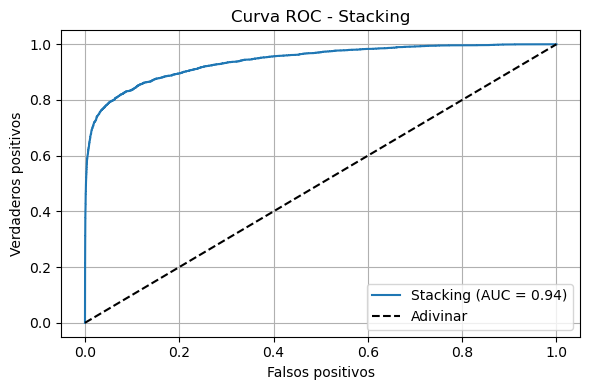

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

# === Curva ROC
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_proba_stack)
auc_stack = roc_auc_score(y_test, y_proba_stack)
print(f"AUC final sobre test (Stacking): {auc_stack:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr_stack, tpr_stack, label=f'Stacking (AUC = {auc_stack:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Stacking")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


intento 3

In [15]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import time

# === Definir modelos base (asegúrate de que estos estén previamente entrenados o guardados como pipelines)
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model)
]

# === Meta-modelo
meta_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# === Crear stacking
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# === Búsqueda de hiperparámetros del meta-modelo
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_stack = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === Entrenamiento
start_time = time.time()
grid_search_stack.fit(X_train_bal, y_train_bal)
end_time = time.time()

print(f"\nTiempo total entrenamiento y búsqueda (Stacking reducido): {end_time - start_time:.2f} segundos")
print("Mejor C:", grid_search_stack.best_params_['final_estimator__C'])
print("Mejor AUC promedio:", grid_search_stack.best_score_)


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits

Tiempo total entrenamiento y búsqueda (Stacking reducido): 1553.74 segundos
Mejor C: 0.01
Mejor AUC promedio: 0.9962569620772326


In [16]:
from sklearn.metrics import classification_report

# === Mejor modelo del GridSearchCV
best_stack_model = grid_search_stack.best_estimator_

# === Predicciones sobre el test original
y_pred_stack = best_stack_model.predict(X_test)
y_proba_stack = best_stack_model.predict_proba(X_test)[:, 1]

# === Reporte de clasificación
print("\n=== Classification Report - Stacking ===")
print(classification_report(y_test, y_pred_stack))



=== Classification Report - Stacking ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.84      0.65      0.74      3395

    accuracy                           0.96     43266
   macro avg       0.91      0.82      0.86     43266
weighted avg       0.96      0.96      0.96     43266



In [18]:
# === 1. Imports ===
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# === 2. Modelos base (pre-entrenados y escalados) ===
estimators = [
    ('knn', knn_model),        # con escalador dentro
    ('ridge', ridge_model),    # con escalador dentro
    ('rf', rf_model),          # sin escalado
    ('xgb', xgb_model)         # sin escalado
]

# === 3. Meta-modelo más potente ===
meta_model = GradientBoostingClassifier(random_state=42)

# === 4. StackingClassifier con passthrough activado ===
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# === 5. Entrenamiento final con medición de tiempo ===
start_time = time.time()
stacking_clf.fit(X_train_bal, y_train_bal)
end_time = time.time()

print(f"\nTiempo total entrenamiento (Stacking optimizado): {end_time - start_time:.2f} segundos")



Tiempo total entrenamiento (Stacking optimizado): 435.96 segundos



=== Classification Report - Stacking Optimizado ===
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     39871
         1.0       0.88      0.57      0.69      3395

    accuracy                           0.96     43266
   macro avg       0.92      0.78      0.84     43266
weighted avg       0.96      0.96      0.96     43266


AUC final sobre test (Stacking optimizado): 0.9009


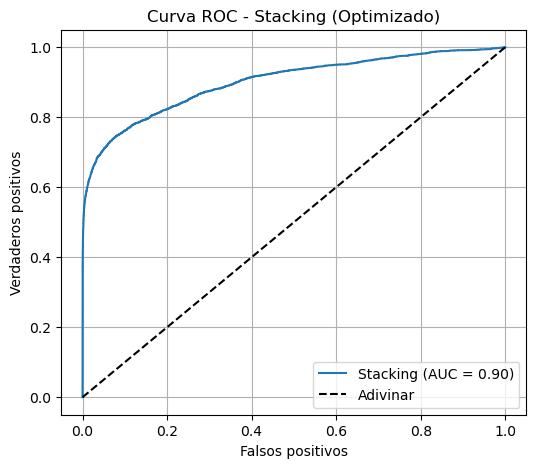

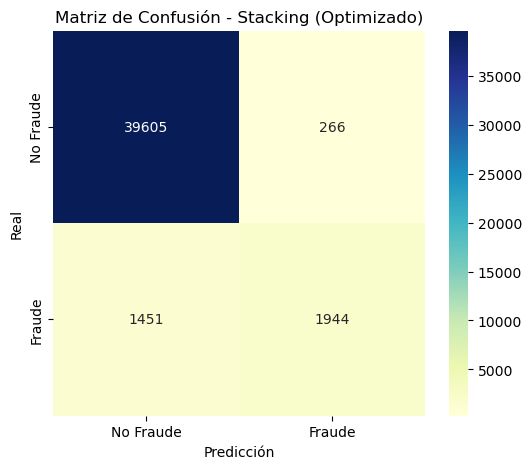

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# === Predicciones con el stacking optimizado ===
y_pred_stack = stacking_clf.predict(X_test)
y_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]

# === Reporte de clasificación ===
print("\n=== Classification Report - Stacking Optimizado ===")
print(classification_report(y_test, y_pred_stack))

# === Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
auc_score = roc_auc_score(y_test, y_proba_stack)
print(f"\nAUC final sobre test (Stacking optimizado): {auc_score:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Stacking (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Stacking (Optimizado)")
plt.legend()
plt.grid(True)
plt.show()

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["No Fraude", "Fraude"], yticklabels=["No Fraude", "Fraude"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Stacking (Optimizado)")
plt.show()


In [20]:
# === 1. Imports ===
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
import time

# === 2. División y balanceo ===
X = fraude_train.drop(columns=["isfraud"])
y = fraude_train["isfraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

smote = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# === 3. Modelos base con hiperparámetros buenos conocidos ===
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

# === 4. Meta-modelo: Regresión logística con escalado ===
meta_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, C=1.0, random_state=42))
])

# === 5. Crear StackingClassifier ===
stacking = StackingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# === 6. Entrenamiento y evaluación ===
start = time.time()
stacking.fit(X_train_bal, y_train_bal)
end = time.time()

print(f"\nTiempo total de entrenamiento del modelo stacking optimizado: {end - start:.2f} segundos")

# === Predicción y métricas ===
y_pred = stacking.predict(X_test)
y_proba = stacking.predict_proba(X_test)[:, 1]

print("\n=== Classification Report - Stacking Optimizado ===")
print(classification_report(y_test, y_pred))
print(f"\nAUC final sobre test (Stacking optimizado): {roc_auc_score(y_test, y_proba):.4f}")



Tiempo total de entrenamiento del modelo stacking optimizado: 129.24 segundos

=== Classification Report - Stacking Optimizado ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.80      0.63      0.71      3395

    accuracy                           0.96     43266
   macro avg       0.88      0.81      0.84     43266
weighted avg       0.96      0.96      0.96     43266


AUC final sobre test (Stacking optimizado): 0.9391



Tiempo total entrenamiento Stacking Final: 52.84 segundos

=== Classification Report - Modelo Original ===
              precision    recall  f1-score   support

         0.0       0.96      0.65      0.77     39871
         1.0       0.14      0.68      0.23      3395

    accuracy                           0.65     43266
   macro avg       0.55      0.66      0.50     43266
weighted avg       0.90      0.65      0.73     43266


AUC final sobre test: 0.7300


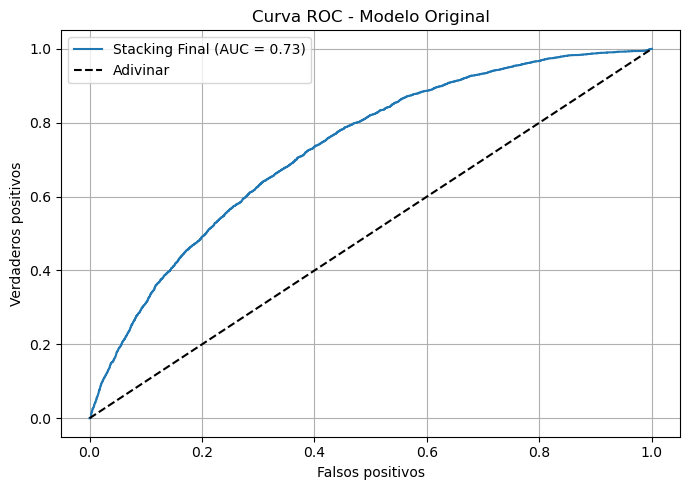

In [21]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time
import joblib

# === Definir modelos base ===
knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=9))
])

sgd_model = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(loss='hinge', alpha=0.001, max_iter=1000, random_state=42))
])

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# === Meta-modelo ===
meta_model = LogisticRegression(
    penalty='l2',
    solver='liblinear',
    C=0.1,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# === Definir stacking ===
stacking_model = StackingClassifier(
    estimators=[
        ('knn', knn_model),
        ('sgd', sgd_model),
        ('xgb', xgb_model)
    ],
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# === Entrenamiento ===
start_time = time.time()
stacking_model.fit(X_train_bal, y_train_bal)
end_time = time.time()

print(f"\nTiempo total entrenamiento Stacking Final: {end_time - start_time:.2f} segundos")

# === Evaluación ===
y_pred = stacking_model.predict(X_test)
y_proba = stacking_model.predict_proba(X_test)[:, 1]

print("\n=== Classification Report - Modelo Original ===")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"\nAUC final sobre test: {auc:.4f}")

# === Guardar modelo ===
joblib.dump(stacking_model, "modelo_original_stacking.pkl")

# === Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Stacking Final (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Modelo Original")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Tiempo total entrenamiento (Stacking optimizado): 30.32 segundos

=== Classification Report - Modelo Original FINAL ===
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     39871
         1.0       0.81      0.71      0.76      3395

    accuracy                           0.96     43266
   macro avg       0.89      0.85      0.87     43266
weighted avg       0.96      0.96      0.96     43266


AUC final sobre test: 0.9412


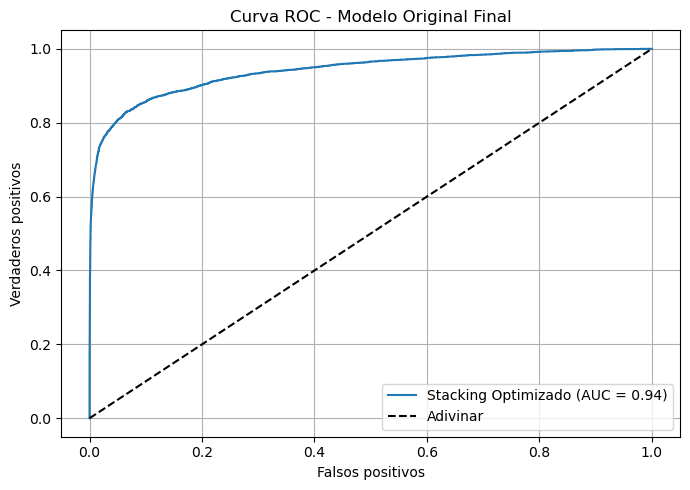

In [35]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time
import joblib

# === Modelos base optimizados ===

# SGD con escalado
sgd_model = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(loss='hinge', alpha=0.001, max_iter=1000, random_state=42))
])

# XGBoost optimizado
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Meta-modelo más tolerante al desbalanceo
meta_model = LogisticRegression(
    penalty='l2',
    solver='liblinear',
    C=1,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# === Stacking optimizado ===
stacking_model = StackingClassifier(
    estimators=[
        ('sgd', sgd_model),
        ('xgb', xgb_model)
    ],
    final_estimator=meta_model,
    passthrough=False,
    cv=5,
    n_jobs=-1
)

# === Entrenamiento ===
start_time = time.time()
stacking_model.fit(X_train_bal, y_train_bal)
end_time = time.time()
print(f"\nTiempo total entrenamiento (Stacking optimizado): {end_time - start_time:.2f} segundos")

# === Evaluación ===
y_pred = stacking_model.predict(X_test)
y_proba = stacking_model.predict_proba(X_test)[:, 1]

print("\n=== Classification Report - Modelo Original FINAL ===")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"\nAUC final sobre test: {auc:.4f}")

# === Guardar modelo ===
joblib.dump(stacking_model, "modelo_original_final.pkl")

# === Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Stacking Optimizado (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Modelo Original Final")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Tiempo total de entrenamiento (Stacking optimizado): 129.54 segundos

=== Classification Report - Modelo Original FINAL ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.87      0.66      0.75      3395

    accuracy                           0.97     43266
   macro avg       0.92      0.83      0.87     43266
weighted avg       0.96      0.97      0.96     43266


AUC final sobre test (Stacking optimizado): 0.9533


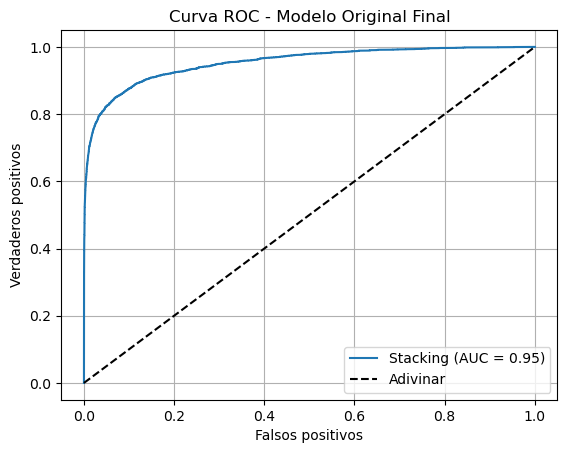

In [23]:
# === 1. Imports necesarios ===
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time

# === 2. Modelos base (entrenados desde cero con mejores hiperparámetros) ===
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )),
    ('xgb', XGBClassifier(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.2,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1,
        random_state=42
    ))
]

# === 3. Meta-modelo: regresión logística escalada ===
meta_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        penalty='l2',
        solver='liblinear',
        C=0.01,
        random_state=42
    ))
])

# === 4. Construir modelo stacking ===
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=False,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# === 5. Entrenar y medir tiempo ===
start_time = time.time()
stacking_model.fit(X_train_bal, y_train_bal)
end_time = time.time()

print(f"\nTiempo total de entrenamiento (Stacking optimizado): {end_time - start_time:.2f} segundos")

# === 6. Predicción y métricas ===
y_pred_stack = stacking_model.predict(X_test)
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

print("\n=== Classification Report - Modelo Original FINAL ===")
print(classification_report(y_test, y_pred_stack))
print(f"\nAUC final sobre test (Stacking optimizado): {roc_auc_score(y_test, y_proba_stack):.4f}")

# === 7. Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
plt.figure()
plt.plot(fpr, tpr, label=f'Stacking (AUC = {roc_auc_score(y_test, y_proba_stack):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - Modelo Original Final')
plt.legend()
plt.grid(True)
plt.show()


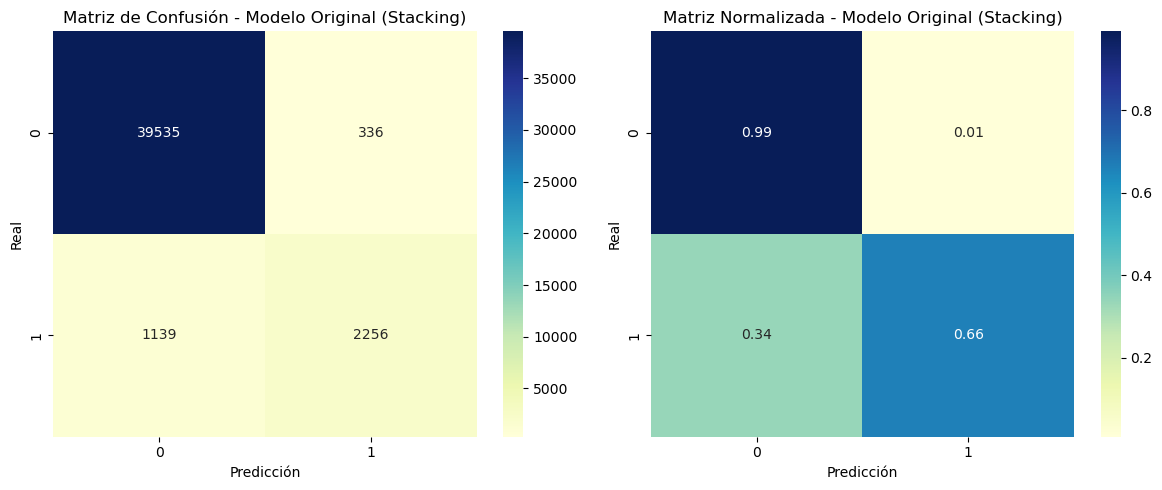

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Matrices de confusión
cm_stack = confusion_matrix(y_test, y_pred_stack)
cm_stack_norm = confusion_matrix(y_test, y_pred_stack, normalize='true')

# === Gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_stack, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0])
axes[0].set_title("Matriz de Confusión - Modelo Original (Stacking)")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_stack_norm, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[1])
axes[1].set_title("Matriz Normalizada - Modelo Original (Stacking)")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()



Tiempo total de entrenamiento (Stacking optimizado): 137.04 segundos

=== Classification Report - Modelo Original FINAL ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.87      0.67      0.76      3395

    accuracy                           0.97     43266
   macro avg       0.92      0.83      0.87     43266
weighted avg       0.96      0.97      0.96     43266


AUC final sobre test (Stacking optimizado): 0.9518


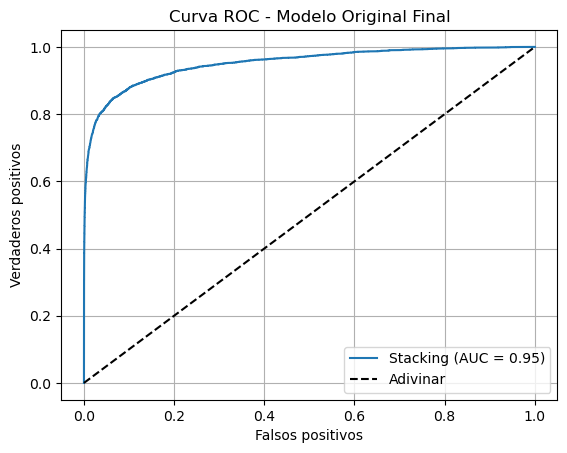

In [5]:
# === 1. Imports necesarios ===
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time

# === 2. Modelos base (entrenados desde cero con mejores hiperparámetros) ===
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )),
    ('xgb', XGBClassifier(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.2,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1,
        random_state=42
    ))
]

# === 3. Meta-modelo: regresión logística escalada ===
meta_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        penalty='l2',
        solver='liblinear',
        C=0.01,
        random_state=42
    ))
])

# === 4. Construir modelo stacking ===
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# === 5. Entrenar y medir tiempo ===
start_time = time.time()
stacking_model.fit(X_train_bal, y_train_bal)
end_time = time.time()

print(f"\nTiempo total de entrenamiento (Stacking optimizado): {end_time - start_time:.2f} segundos")

# === 6. Predicción y métricas ===
y_pred_stack = stacking_model.predict(X_test)
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

print("\n=== Classification Report - Modelo Original FINAL ===")
print(classification_report(y_test, y_pred_stack))
print(f"\nAUC final sobre test (Stacking optimizado): {roc_auc_score(y_test, y_proba_stack):.4f}")

# === 7. Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
plt.figure()
plt.plot(fpr, tpr, label=f'Stacking (AUC = {roc_auc_score(y_test, y_proba_stack):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - Modelo Original Final')
plt.legend()
plt.grid(True)
plt.show()


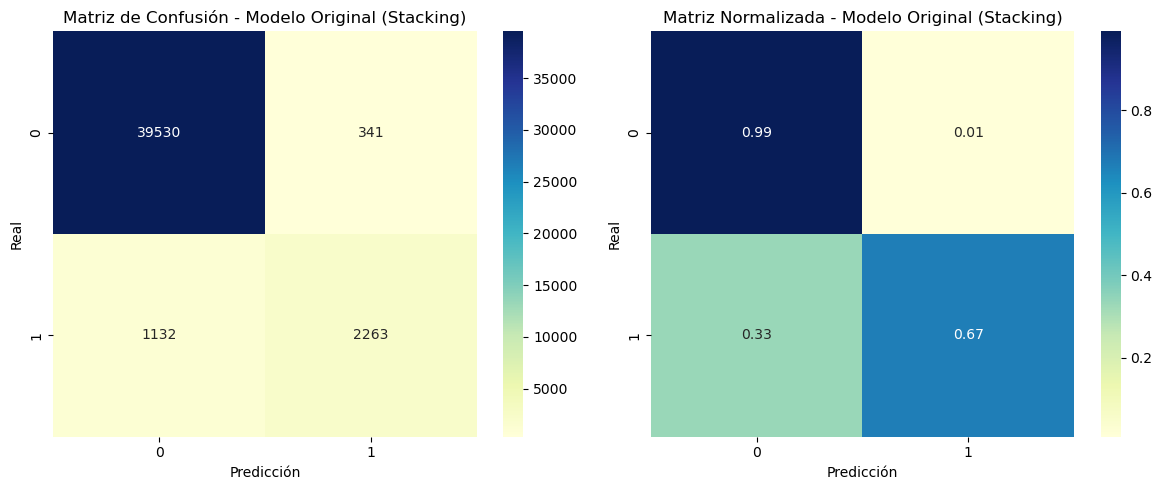

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Matrices de confusión
cm_stack = confusion_matrix(y_test, y_pred_stack)
cm_stack_norm = confusion_matrix(y_test, y_pred_stack, normalize='true')

# === Gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_stack, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0])
axes[0].set_title("Matriz de Confusión - Modelo Original (Stacking)")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_stack_norm, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[1])
axes[1].set_title("Matriz Normalizada - Modelo Original (Stacking)")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()


Distribución post-balanceo: Counter({0.0: 89700, 1.0: 89700})


c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:49:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Tiempo total de entrenamiento (Stacking con meta-modelo XGB): 190.05 segundos

=== Classification Report - Stacking (meta-modelo XGB) ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.88      0.67      0.76      3395

    accuracy                           0.97     43266
   macro avg       0.93      0.83      0.87     43266
weighted avg       0.97      0.97      0.97     43266

AUC final sobre test: 0.9612


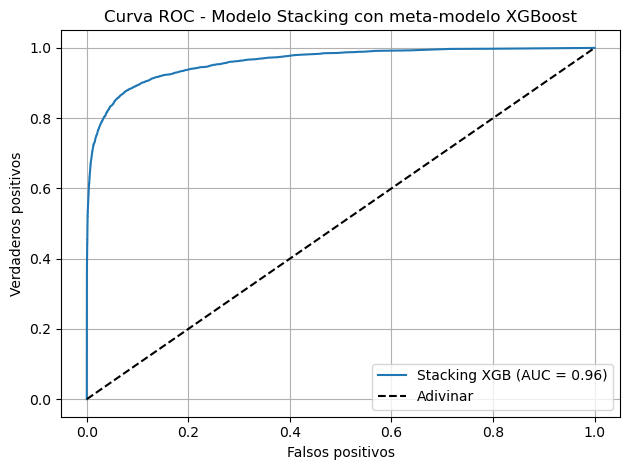

In [29]:
# === 1. Imports necesarios ===
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from collections import Counter

# === 2. Balanceo y división ===
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

X = fraude_train.drop(columns=["isfraud"])
y = fraude_train["isfraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)
print("Distribución post-balanceo:", Counter(y_train_bal))

# === 3. Modelos base entrenados con hiperparámetros óptimos ===
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )),
    ('xgb', XGBClassifier(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.2,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1,
        random_state=42
    ))
]

# === 4. Meta-modelo NO lineal: XGBClassifier liviano ===
meta_model = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

# === 5. Construcción del modelo stacking ===
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# === 6. Entrenamiento ===
start_time = time.time()
stacking_model.fit(X_train_bal, y_train_bal)
end_time = time.time()
print(f"\nTiempo total de entrenamiento (Stacking con meta-modelo XGB): {end_time - start_time:.2f} segundos")

# === 7. Evaluación ===
y_pred = stacking_model.predict(X_test)
y_proba = stacking_model.predict_proba(X_test)[:, 1]

print("\n=== Classification Report - Stacking (meta-modelo XGB) ===")
print(classification_report(y_test, y_pred))
print(f"AUC final sobre test: {roc_auc_score(y_test, y_proba):.4f}")

# === 8. Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Stacking XGB (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - Modelo Stacking con meta-modelo XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Distribución post-balanceo: Counter({0.0: 89700, 1.0: 89700})


c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:25:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Tiempo total de entrenamiento (Stacking): 135.50 segundos

=== Classification Report estándar ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.88      0.67      0.76      3395

    accuracy                           0.97     43266
   macro avg       0.93      0.83      0.87     43266
weighted avg       0.97      0.97      0.97     43266

AUC estándar sobre test: 0.9612

Mejor threshold: 0.38 con F1-score: 0.7707

=== Classification Report con threshold ajustado ===
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     39871
         1.0       0.84      0.72      0.77      3395

    accuracy                           0.97     43266
   macro avg       0.91      0.85      0.88     43266
weighted avg       0.97      0.97      0.97     43266

AUC con threshold ajustado: 0.9612


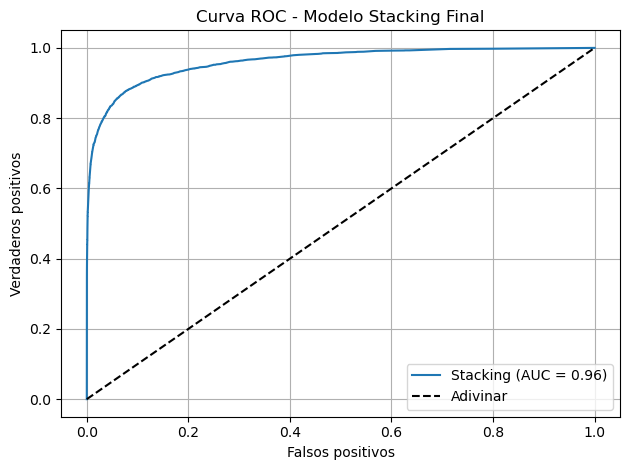

In [32]:
# === 1. Imports necesarios ===
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score
from imblearn.combine import SMOTETomek
from collections import Counter

# === 2. Cargar y dividir datos ===
fraude_train = pd.read_csv("fraude_train.csv")
X = fraude_train.drop(columns=["isfraud"])
y = fraude_train["isfraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# === 3. Balanceo solo sobre entrenamiento ===
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)
print("Distribución post-balanceo:", Counter(y_train_bal))

# === 4. Modelos base ===
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )),
    ('xgb', XGBClassifier(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.2,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1,
        random_state=42
    ))
]

# === 5. Meta-modelo NO lineal ===
meta_model = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

# === 6. Modelo Stacking ===
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# === 7. Entrenamiento ===
start_time = time.time()
stacking_model.fit(X_train_bal, y_train_bal)
end_time = time.time()
print(f"\nTiempo total de entrenamiento (Stacking): {end_time - start_time:.2f} segundos")

# === 8. Evaluación ===
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]
y_pred_stack = stacking_model.predict(X_test)

print("\n=== Classification Report estándar ===")
print(classification_report(y_test, y_pred_stack))
print(f"AUC estándar sobre test: {roc_auc_score(y_test, y_proba_stack):.4f}")

# === 9. Ajuste de umbral ===
thresholds = np.linspace(0.1, 0.9, 81)
best_f1 = 0
best_threshold = 0.5

for th in thresholds:
    y_pred_th = (y_proba_stack >= th).astype(int)
    f1 = f1_score(y_test, y_pred_th)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = th

print(f"\nMejor threshold: {best_threshold:.2f} con F1-score: {best_f1:.4f}")

# === 10. Reporte con mejor threshold ===
y_pred_optimo = (y_proba_stack >= best_threshold).astype(int)

print("\n=== Classification Report con threshold ajustado ===")
print(classification_report(y_test, y_pred_optimo))
print(f"AUC con threshold ajustado: {roc_auc_score(y_test, y_proba_stack):.4f}")

# === 11. Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
plt.figure()
plt.plot(fpr, tpr, label=f'Stacking (AUC = {roc_auc_score(y_test, y_proba_stack):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - Modelo Stacking Final')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Distribución post-balanceo: Counter({0.0: 89700, 1.0: 89700})

Tiempo total de entrenamiento (Stacking con GB): 287.88 segundos

Mejor threshold: 0.34 con F1-score: 0.7693

=== Classification Report con threshold ajustado ===
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     39871
         1.0       0.82      0.73      0.77      3395

    accuracy                           0.97     43266
   macro avg       0.90      0.86      0.88     43266
weighted avg       0.96      0.97      0.96     43266

AUC con threshold ajustado: 0.9614


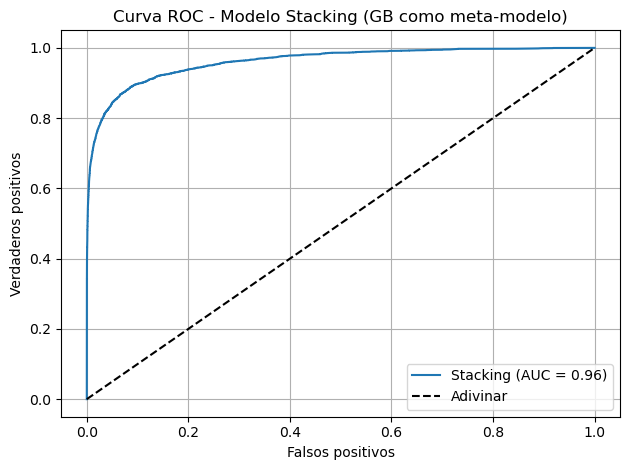

In [48]:
# === 1. Imports necesarios ===
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score
from imblearn.combine import SMOTETomek
from collections import Counter

# === 2. Cargar datos ===
fraude_train = pd.read_csv("fraude_train.csv")
X = fraude_train.drop(columns=["isfraud"])
y = fraude_train["isfraud"]

# === 3. División y balanceo solo en entrenamiento ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)
print("Distribución post-balanceo:", Counter(y_train_bal))

# === 4. Modelos base ===
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=200, max_depth=None, min_samples_split=2,
        min_samples_leaf=1, max_features='sqrt',
        random_state=42, n_jobs=-1
    )),
    ('xgb', XGBClassifier(
        n_estimators=300, max_depth=7, learning_rate=0.2,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric='logloss', 
        n_jobs=-1, random_state=42
    ))
]

# === 5. Meta-modelo: Gradient Boosting ===
meta_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# === 6. Modelo Stacking ===
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# === 7. Entrenamiento ===
start_time = time.time()
stacking_model.fit(X_train_bal, y_train_bal)
end_time = time.time()
print(f"\nTiempo total de entrenamiento (Stacking con GB): {end_time - start_time:.2f} segundos")

# === 8. Predicciones ===
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

# === 9. Threshold óptimo ===
thresholds = np.linspace(0.1, 0.9, 81)
best_f1 = 0
best_threshold = 0.5
for th in thresholds:
    y_pred_th = (y_proba_stack >= th).astype(int)
    f1 = f1_score(y_test, y_pred_th)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = th
print(f"\nMejor threshold: {best_threshold:.2f} con F1-score: {best_f1:.4f}")

# === 10. Reporte ===
y_pred_final = (y_proba_stack >= best_threshold).astype(int)
print("\n=== Classification Report con threshold ajustado ===")
print(classification_report(y_test, y_pred_final))
print(f"AUC con threshold ajustado: {roc_auc_score(y_test, y_proba_stack):.4f}")

# === 11. Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
plt.figure()
plt.plot(fpr, tpr, label=f'Stacking (AUC = {roc_auc_score(y_test, y_proba_stack):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - Modelo Stacking (GB como meta-modelo)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Modelos Original definitivo**


Distribución post-balanceo: Counter({0.0: 89700, 1.0: 89700})

Tiempo total de entrenamiento (Stacking): 134.42 segundos

Mejor threshold: 0.38 con F1-score: 0.7707

=== Classification Report con threshold ajustado ===
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     39871
         1.0       0.84      0.72      0.77      3395

    accuracy                           0.97     43266
   macro avg       0.91      0.85      0.88     43266
weighted avg       0.97      0.97      0.97     43266

AUC con threshold ajustado: 0.9612


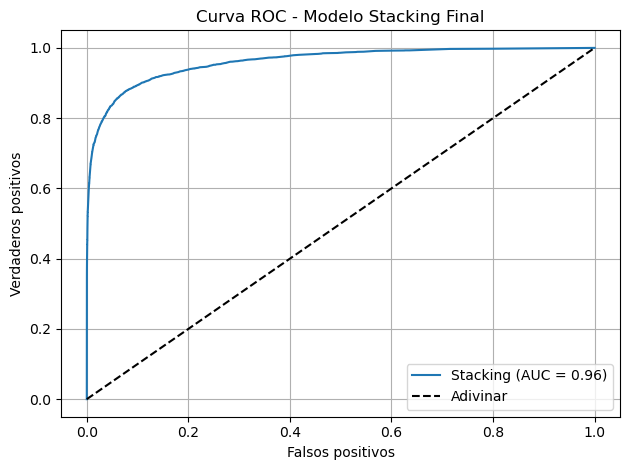

In [37]:
# === 1. Imports necesarios ===
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score
from imblearn.combine import SMOTETomek
from collections import Counter

# === 2. Cargar datos ===
fraude_train = pd.read_csv("fraude_train.csv")
X = fraude_train.drop(columns=["isfraud"])
y = fraude_train["isfraud"]

# === 3. División y balanceo solo en entrenamiento ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)
print("Distribución post-balanceo:", Counter(y_train_bal))

# === 4. Modelos base ===
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=200, max_depth=None, min_samples_split=2,
        min_samples_leaf=1, max_features='sqrt',
        random_state=42, n_jobs=-1
    )),
    ('xgb', XGBClassifier(
        n_estimators=300, max_depth=7, learning_rate=0.2,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric='logloss', 
        n_jobs=-1, random_state=42
    ))
]

# === 5. Meta-modelo NO lineal: XGBoost simplificado ===
meta_model = XGBClassifier(
    n_estimators=50, max_depth=3, learning_rate=0.1,
    subsample=0.9, colsample_bytree=0.9,
    eval_metric='logloss', 
    n_jobs=-1, random_state=42
)

# === 6. Modelo Stacking ===
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# === 7. Entrenamiento ===
start_time = time.time()
stacking_model.fit(X_train_bal, y_train_bal)
end_time = time.time()
print(f"\nTiempo total de entrenamiento (Stacking): {end_time - start_time:.2f} segundos")

# === 8. Predicciones ===
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

# === 9. Buscar threshold óptimo ===
thresholds = np.linspace(0.1, 0.9, 81)
best_f1 = 0
best_threshold = 0.5

for th in thresholds:
    y_pred_th = (y_proba_stack >= th).astype(int)
    f1 = f1_score(y_test, y_pred_th)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = th

print(f"\nMejor threshold: {best_threshold:.2f} con F1-score: {best_f1:.4f}")

# === 10. Reporte con threshold ajustado ===
y_pred_final = (y_proba_stack >= best_threshold).astype(int)

print("\n=== Classification Report con threshold ajustado ===")
print(classification_report(y_test, y_pred_final))
print(f"AUC con threshold ajustado: {roc_auc_score(y_test, y_proba_stack):.4f}")

# === 11. Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
plt.figure()
plt.plot(fpr, tpr, label=f'Stacking (AUC = {roc_auc_score(y_test, y_proba_stack):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC - Modelo Stacking Final')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


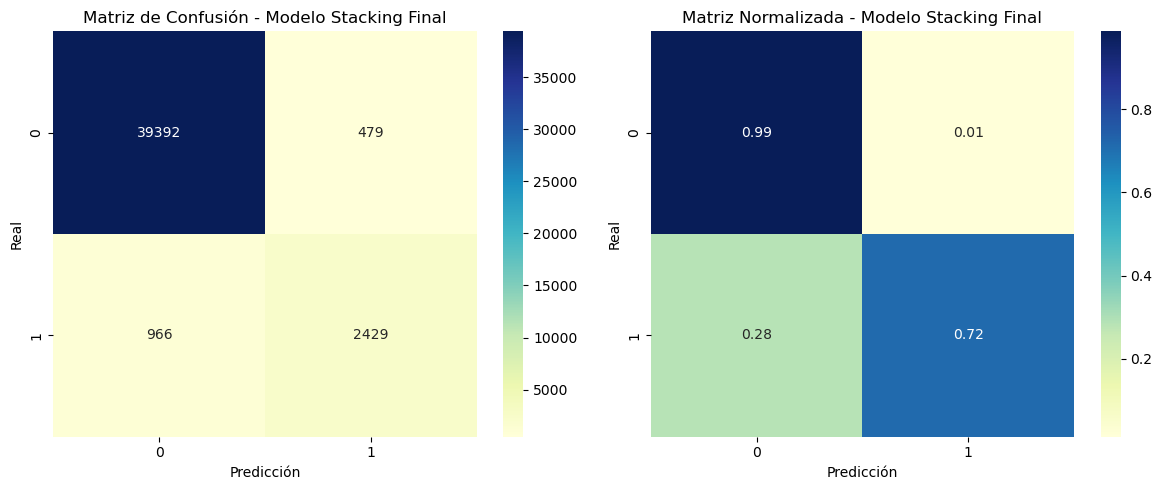

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# === 12. Matrices de confusión ===
cm_final = confusion_matrix(y_test, y_pred_final)
cm_final_norm = confusion_matrix(y_test, y_pred_final, normalize='true')

# === 13. Gráficos lado a lado ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_final, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0])
axes[0].set_title("Matriz de Confusión - Modelo Stacking Final")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_final_norm, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[1])
axes[1].set_title("Matriz Normalizada - Modelo Stacking Final")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()


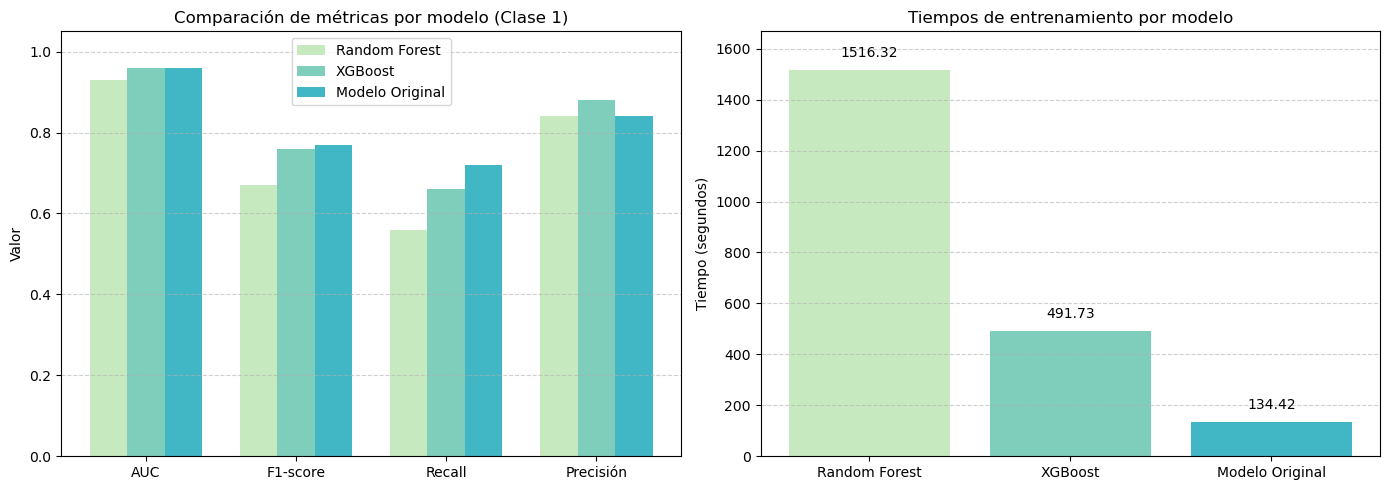

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Nombres de las métricas
metricas = ["AUC", "F1-score", "Recall", "Precisión"]

# Valores por modelo para clase positiva (1.0)
rf =     [0.93, 0.67, 0.56, 0.84]
xgb =    [0.96, 0.76, 0.66, 0.88]
stack =  [0.96, 0.77, 0.72, 0.84]

# Tiempos de entrenamiento
tiempos = [1516.32, 491.73, 134.42]

# Datos combinados
valores = np.array([rf, xgb, stack])
modelos = ["Random Forest", "XGBoost", "Modelo Original"]
colores = ['#c7e9c0', '#7fcdbb', '#41b6c4']  # Paleta tipo YlGnBu

# Coordenadas X
x = np.arange(len(metricas))
width = 0.25

# Crear gráfico de métricas y tiempos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# === GRÁFICO DE MÉTRICAS ===
for i in range(len(modelos)):
    ax1.bar(x + i * width, valores[i], width, label=modelos[i], color=colores[i])

ax1.set_ylabel("Valor")
ax1.set_title("Comparación de métricas por modelo (Clase 1)")
ax1.set_xticks(x + width)
ax1.set_xticklabels(metricas)
ax1.set_ylim(0, 1.05)
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)

# === GRÁFICO DE TIEMPOS ===
x2 = np.arange(len(modelos))
bars = ax2.bar(x2, tiempos, color=colores)

# Etiquetas de valores encima de las barras
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 40, f'{height:.2f}', ha='center', va='bottom')

ax2.set_ylabel("Tiempo (segundos)")
ax2.set_title("Tiempos de entrenamiento por modelo")
ax2.set_xticks(x2)
ax2.set_xticklabels(modelos)
ax2.set_ylim(0, max(tiempos)*1.1)
ax2.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
